In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [24, 5 ]

data = pd.read_csv('EUR_USD Train.csv')
data = data.rename(columns = {'Price':'Close'})
data = data.iloc[::-1]
data['Date'] = pd.to_datetime(data['Date'])
data = data.drop(columns=['Change %'])
#data['Close'] = data['Close'].str.replace(',','').astype(float)

safedata = data
safedata['Change'] = ((safedata.Close - safedata.Close.shift()) * 100 / (safedata.Close.shift()))
safedata.head()

,Date,Close,Open,High,Low,Change
4999,2000-01-03,1.0265,1.0052,1.0282,1.0050,NaN
4998,2000-01-04,1.0312,1.0244,1.0347,1.0213,0.457867
4997,2000-01-05,1.0316,1.0295,1.0404,1.0282,0.038790
4996,2000-01-06,1.0324,1.0325,1.0419,1.0275,0.077549
4995,2000-01-07,1.0292,1.0327,1.0333,1.0252,-0.309957


# Test Case

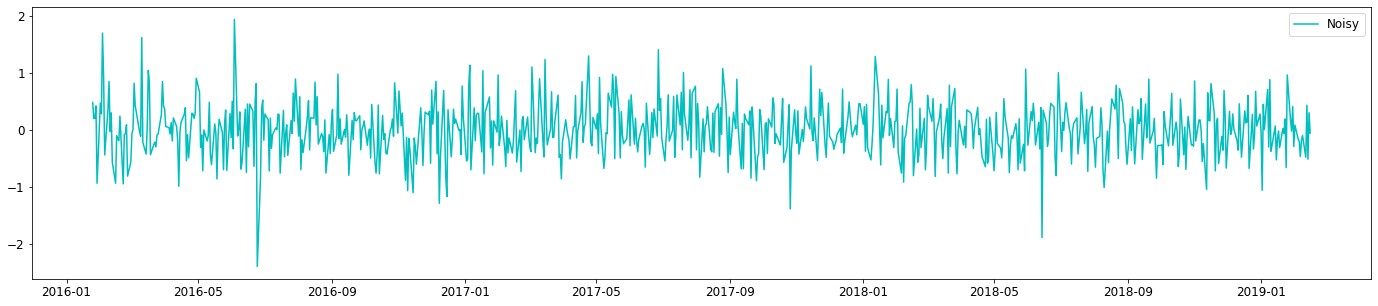

In [473]:
forecast = 10
train = 800
quantity = train + forecast

data = safedata[-quantity:-forecast]
data = data.reset_index(drop = True)
plt.plot(data.Date,data.Change,color='c', label='Noisy')
plt.legend()

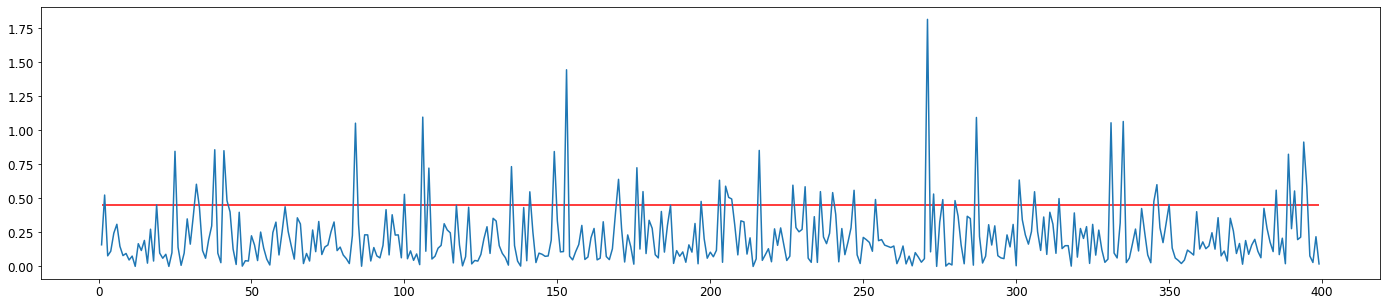

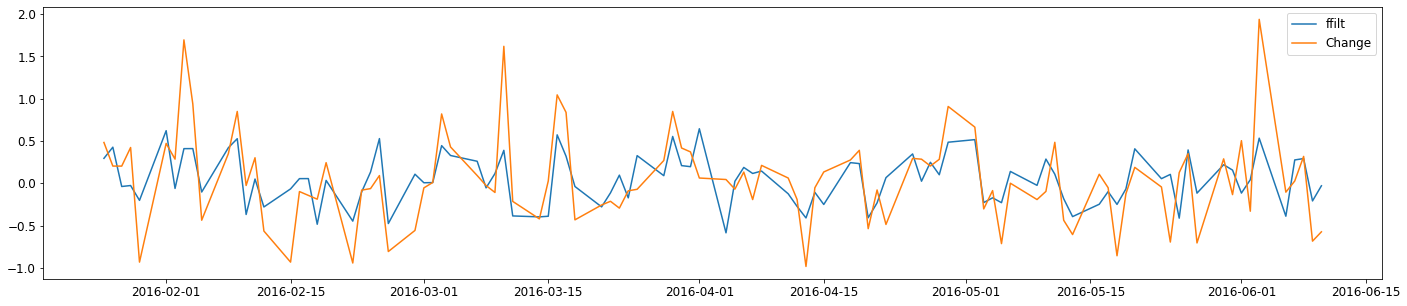

In [414]:
n = len(data.Change)
dt = 1/n

fhat = np.fft.fft(data.Change,n)
PSD = fhat * np.conj(fhat) / n
freq = (1/(dt*n))* np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

std = np.std(PSD)
mean = np.mean(PSD)
maxval = mean + std #get the outliers

indices = PSD >= maxval

plt.plot(freq[L],PSD[L])
plt.hlines(y=maxval, xmin=L[0], xmax=L[-1], color='r')
plt.show()

PSDclean = PSD * indices
fhat = fhat * indices 
ffilt = np.fft.ifft(fhat)

lookup = 100

plt.plot(data.Date[:lookup], ffilt[:lookup], label = 'ffilt')
# plt.show()
plt.plot(data.Date[:lookup], data.Change[:lookup], label = 'Change')
plt.legend()
plt.show()

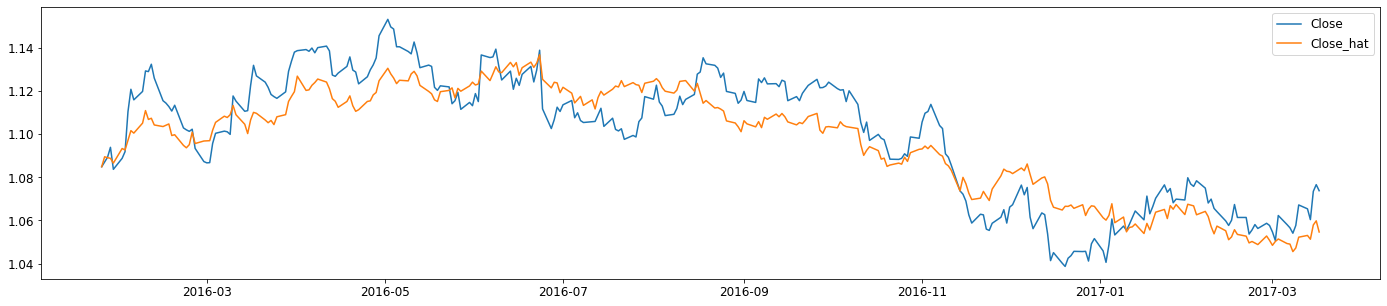

In [415]:
data['ffilt'] = ffilt.real
data['Close_hat'] = np.NaN
data['Close_hat'][0] = data['Close'][0]
for i in range(1 , len(data)):
    data.loc[i, 'Close_hat'] = (data.ffilt[i] * data.Close_hat[i-1] / 100) + data.Close_hat[i-1]

lookup = 500
plt.plot(data.Date[:-lookup] , data.Close[:-lookup], label = "Close")
plt.plot(data.Date[:-lookup] , data.Close_hat[:-lookup], label = "Close_hat")
plt.legend()

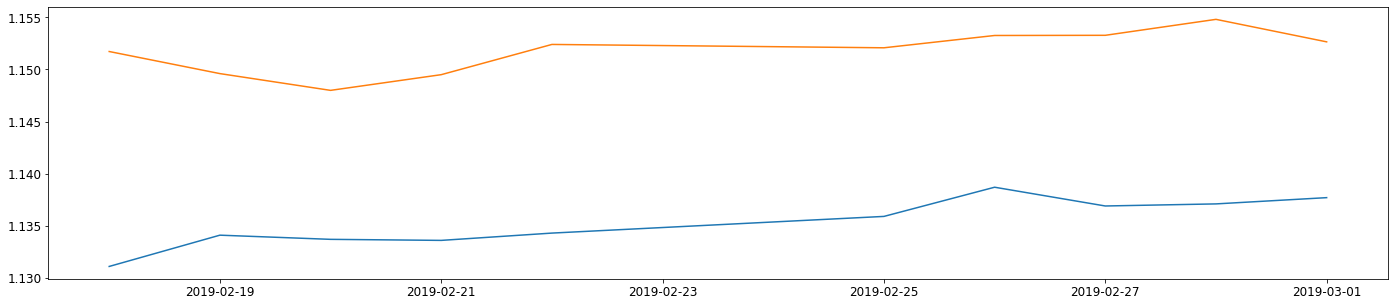

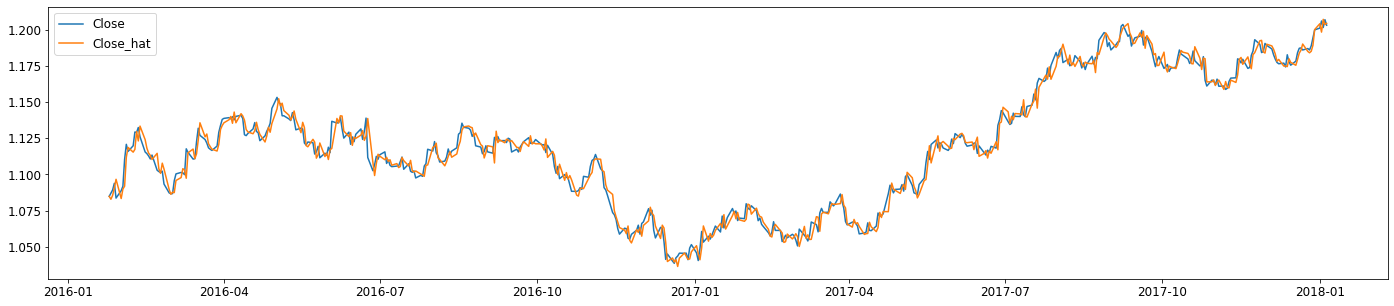

In [417]:
freqs = freq[L] * indices[L]
true_freqs = np.delete(freqs , np.where(freqs == 0))
phase = np.angle(fhat[L]) +np.pi/2
ampli = np.sqrt(fhat[L].real**2 + fhat[L].imag**2)/500

new_data = safedata[-quantity:]
new_data = new_data.reset_index(drop = True)
fin = quantity/train

t = np.arange(0,fin,dt)

fr = true_freqs[0]
A = ampli[int(fr-1)]
phi = phase[int(fr-1)]
f = A*np.sin(2*np.pi*fr*t + phi)
for fr in true_freqs[1:]:
    f = f + A*np.sin(2*np.pi*fr*t + phi) 

new_data['ffilt'] = f.real
new_data['Close_hat'] = np.NaN
new_data['Close_hat'][0] = new_data['Close'][0]
for i in range(1 , len(new_data)):
    if i <= train:
        new_data.loc[i, 'Close_hat'] = (new_data.ffilt[i] * new_data.Close[i-1] / 100) + new_data.Close[i-1]
    else:
        new_data.loc[i, 'Close_hat'] = (new_data.ffilt[i] * new_data.Close_hat[i-1] / 100) + new_data.Close_hat[i-1]

lookup = forecast

plt.plot(new_data.Date[-lookup:], new_data.Close[-lookup:])
# plt.show()
plt.plot(new_data.Date[-lookup:], new_data.Close_hat[-lookup:])
plt.show()

lookup = 300
plt.plot(new_data.Date[:-lookup] , new_data.Close[:-lookup], label = "Close")
plt.plot(new_data.Date[:-lookup] , new_data.Close_hat[:-lookup], label = "Close_hat")
plt.legend()
plt.show()


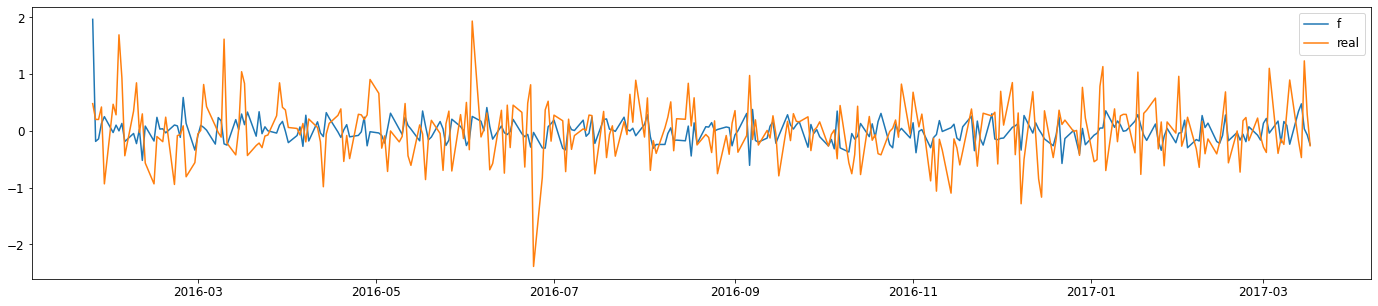

In [420]:
plt.plot(new_data.Date[:lookup],f[:lookup], label = "f")
plt.plot(new_data.Date[:lookup],new_data.Change[:lookup], label = "real")
plt.legend()

In [421]:
estimation = new_data[-forecast:]
estimation['dif'] = (estimation.Close - estimation.Close_hat) * 100 / (estimation.Close)
estimation

,Date,Close,Open,High,Low,Change,ffilt,Close_hat,dif
800,2019-02-18,1.1311,1.1288,1.1337,1.1284,0.141656,1.967122,1.151719,-1.822884
801,2019-02-19,1.1341,1.1310,1.1358,1.1274,0.265229,-0.183957,1.149600,-1.366720
802,2019-02-20,1.1337,1.1342,1.1374,1.1324,-0.035270,-0.139924,1.147991,-1.260599
803,2019-02-21,1.1336,1.1338,1.1368,1.1320,-0.008821,0.131171,1.149497,-1.402368
804,2019-02-22,1.1343,1.1337,1.1360,1.1315,0.061750,0.252314,1.152398,-1.595485
805,2019-02-25,1.1359,1.1338,1.1369,1.1323,0.141056,-0.027927,1.152076,-1.424047
806,2019-02-26,1.1387,1.1366,1.1404,1.1343,0.246501,0.102467,1.153256,-1.278321
807,2019-02-27,1.1369,1.1396,1.1404,1.1360,-0.158075,0.001462,1.153273,-1.440154
808,2019-02-28,1.1371,1.1371,1.1421,1.1357,0.017592,0.132721,1.154804,-1.556920
809,2019-03-01,1.1377,1.1372,1.1410,1.1353,0.052766,-0.186883,1.152646,-1.313668


# Simulations

In [476]:
forecast = 5
train = 800
mindif = 0.5 # minimum spected change (%) in price to trigger the position
quantity = train + forecast

profits = []
deviations = []
opens = []
targets = []
futures = []
desitions = []

for shift in range(1,len(safedata)-train-forecast,forecast):

    data = safedata[-quantity-shift:-forecast-shift]
    data = data.reset_index(drop = True)

    n = len(data.Change)
    dt = 1/n

    fhat = np.fft.fft(data.Change,n)
    PSD = fhat * np.conj(fhat) / n
    freq = (1/(dt*n))* np.arange(n)
    L = np.arange(1, np.floor(n/2), dtype='int')

    std = np.std(PSD)
    mean = np.mean(PSD)
    maxval = mean + std #get the outliers

    indices = PSD >= maxval

    PSDclean = PSD * indices
    fhat = fhat * indices 
    ffilt = np.fft.ifft(fhat)

    freqs = freq[L] * indices[L]
    true_freqs = np.delete(freqs , np.where(freqs == 0))
    phase = np.angle(fhat[L]) +np.pi/2
    ampli = np.sqrt(fhat[L].real**2 + fhat[L].imag**2)/500

    new_data = safedata[-quantity-shift:-shift]
    new_data = new_data.reset_index(drop = True)
    fin = quantity/train

    t = np.arange(0,fin,dt)

    fr = true_freqs[0]
    A = ampli[int(fr-1)]
    phi = phase[int(fr-1)]
    f = A*np.sin(2*np.pi*fr*t + phi)
    for fr in true_freqs[1:]:
        f = f + A*np.sin(2*np.pi*fr*t + phi) 

    new_data['ffilt'] = f.real
    new_data['Close_hat'] = np.NaN
    new_data['Close_hat'][0] = new_data['Close'][0]
    for i in range(1 , len(new_data)):
        if i <= train:
            new_data.loc[i, 'Close_hat'] = (new_data.ffilt[i] * new_data.Close[i-1] / 100) + new_data.Close[i-1]
        else:
            new_data.loc[i, 'Close_hat'] = (new_data.ffilt[i] * new_data.Close_hat[i-1] / 100) + new_data.Close_hat[i-1]

    estimation = new_data[-forecast:]
    estimation['dif'] = (estimation.Close - estimation.Close_hat) * 100 / (estimation.Close)
    estimation = estimation.reset_index(drop = True)
    m_error = round(np.mean(estimation.dif),2)
    f_error = round(estimation.dif[forecast-1],2)

    target = round(estimation['Close_hat'][forecast - 1], 5)
    actual = round(estimation['Open'][0], 5)
    future = round(estimation['Close'][forecast - 1], 5)

    desition = 'LONG' if target > actual else 'SHORT'
    expected = (target + -actual)*100/actual if desition == 'LONG' else (actual + -target)*100/actual

    if expected > mindif:
        profit = (future + -actual)*100/actual if desition == 'LONG' else (actual + -future)*100/actual
    else:
        profit = 0
        desition = 'NOTHING'

    print(f'deviation: {f_error}% | Open Price: {actual} | Target: {target} | Real: {future} | desition: {desition} |P&L: {round(profit,2)}%')

    deviations.append(f_error)
    opens.append(actual)
    targets.append(target)
    futures.append(future)
    desitions.append(desition)
    profits.append(profit)

dict = {'Deviation': deviations, 'Open': opens, 'Target': targets, 'Real_close' : futures, 'Desition': desitions, 'Profit': profits}
result = pd.DataFrame(dict)

f = round(np.mean(result.Deviation),2)
mp = round(np.mean(result.Profit),2)
sp = round(sum(result.Profit),2)
print(f'Mean of deviation of expected: {f}% | Mean of Profits: {mp}% | Sum of profits: {sp}%')


deviation: -1.32% | Open Price: 1.1337 | Target: 1.15208 | Real: 1.1371 | desition: LONG |P&L: 0.3%
deviation: -1.49% | Open Price: 1.1295 | Target: 1.15047 | Real: 1.1336 | desition: LONG |P&L: 0.36%
deviation: -2.4% | Open Price: 1.1346 | Target: 1.15723 | Real: 1.1301 | desition: LONG |P&L: -0.4%
deviation: -3.11% | Open Price: 1.1447 | Target: 1.16936 | Real: 1.1341 | desition: LONG |P&L: -0.93%
deviation: -1.21% | Open Price: 1.1306 | Target: 1.1584 | Real: 1.1446 | desition: LONG |P&L: 1.24%
deviation: -3.35% | Open Price: 1.1389 | Target: 1.16852 | Real: 1.1306 | desition: LONG |P&L: -0.73%
deviation: -3.81% | Open Price: 1.1499 | Target: 1.18318 | Real: 1.1398 | desition: LONG |P&L: -0.88%
deviation: -1.88% | Open Price: 1.1393 | Target: 1.1716 | Real: 1.15 | desition: LONG |P&L: 0.94%
deviation: -2.96% | Open Price: 1.1429 | Target: 1.17313 | Real: 1.1394 | desition: LONG |P&L: -0.31%
deviation: -3.34% | Open Price: 1.1447 | Target: 1.18117 | Real: 1.143 | desition: LONG |P&L:

In [474]:
result

,Deviation,Open,Target,Real_close,Desition,Profit
0,-1.13,1.1295,1.14991,1.1371,LONG,0.672864
1,-3.45,1.1447,1.16911,1.1301,LONG,-1.275443
2,-2.33,1.1389,1.17130,1.1446,LONG,0.500483
3,-2.83,1.1393,1.17207,1.1398,LONG,0.043887
4,-4.06,1.1447,1.18569,1.1394,LONG,-0.463003
...,...,...,...,...,...,...
414,0.76,1.0760,1.07900,1.0873,NOTHING,0.000000
415,3.79,1.0614,1.03496,1.0757,SHORT,-1.347277
416,-6.78,1.0974,1.13434,1.0623,LONG,-3.198469
417,-2.00,1.0818,1.11895,1.0970,LONG,1.405066


In [477]:
shorts = result[result.Desition == 'SHORT']
longs = result[result.Desition == 'LONG']

print(sum(shorts.Profit), np.mean(shorts.Profit), sum(longs.Profit), np.mean(longs.Profit))

32.13304859810566 0.08523355065810512 29.14055546159611 0.07377355813062306
